In [2]:
from typing import Optional
from tqdm.auto import tqdm
import numpy as np
import torch
from torch import nn
from torch.nn import functional as F
import pytorch_lightning as pl
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score
import matplotlib.pyplot as plt

/home/shate/.local/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


ModuleNotFoundError: No module named 'numpy'

In [169]:
mnist = ImageDataModule(MNIST)
mnist.prepare_data()
mnist.setup()

In [170]:
cifar10 = ImageDataModule(CIFAR10)
cifar10.prepare_data()
cifar10.setup()

Files already downloaded and verified
Files already downloaded and verified


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


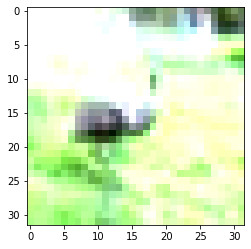

In [171]:
x = cifar10.train_dataloader().dataset[1][0]
plt.imshow(x.numpy().transpose(1, 2, 0))

In [172]:
from pytorch_lightning import LightningModule
import wandb
from pytorch_lightning.loggers import WandbLogger
from abc import abstractmethod  
from collections import OrderedDict

class MLP(nn.Module):
    def __init__(self, in_size, n_classes):
        super().__init__()
        self.model = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_size, in_size // 2),
            nn.ReLU(),
            nn.Linear(in_size // 2, in_size // 4),
            nn.ReLU(),
            nn.Linear(in_size // 4, n_classes)
        )
        
    def forward(self, x):
        return F.log_softmax(self.model(x), dim=1)
    
    
class DeepCNN(nn.Module):
    def __init__(self, in_channels, in_dim, n_classes):
        super().__init__()
        cnn_flat_out_dim = int(in_dim * in_dim * 3 / 4)
        self.model = nn.Sequential(OrderedDict([
            # [3, in_dim, in_dim]
            ('cnn_block_1', self.get_cnn_block(in_channels,    out_channels=6,  kernel_size=3, padding=1)),   # [6,  in_dim / 2, in_dim / 2]
            ('cnn_block_2', self.get_cnn_block(in_channels=6,  out_channels=12, kernel_size=3, padding=1)),   # [12, in_dim / 4, in_dim / 4]
            ('flatten', nn.Flatten()),                                                                        # 12 * in_dim / 4 * in_dim / 4 = in_dim * in_dim * 3 / 4
            ('linear_1', nn.Linear(cnn_flat_out_dim, cnn_flat_out_dim // 2)),                                 # in_dim * in_dim * 3 / 8 
            ('relu', nn.ReLU()),                                                                              # in_dim * in_dim * 3 / 8 
            ('linear_2', nn.Linear(cnn_flat_out_dim // 2, n_classes))                                         # n_classes
        ]))
        
    def get_cnn_block(self, in_channels, out_channels, kernel_size, padding):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size, padding=padding),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        
    def forward(self, x):
        return F.log_softmax(self.model(x), dim=1)


class ImageClassifier(LightningModule):
    def __init__(self, in_dims, classifier: nn.Module, learning_rate: float = 1e-3):
        super().__init__()
        self.classifier = classifier
        self.learning_rate = learning_rate
        self.save_hyperparameters('in_dims', 'learning_rate')
    
    def forward(self, x):
        return self.classifier(x)

    def training_step(self, batch, batch_idx):
        x, labels = batch
        log_probs = self(x)
        preds = log_probs.argmax(axis=1)
        loss = F.nll_loss(log_probs, labels)
        acc = accuracy_score(labels.cpu(), preds.cpu())
        self.log("train/loss", loss, on_step=False, on_epoch=True)
        self.log("train/acc", acc, on_step=False, on_epoch=True)
        return loss
    
    def validation_step(self, batch, batch_idx):
        x, labels = batch
        log_probs = self(x)
        preds = log_probs.argmax(axis=1)
        loss = F.nll_loss(log_probs, labels)
        acc = accuracy_score(labels.cpu(), preds.cpu())
        self.log('val/loss', loss, on_step=False, on_epoch=True)
        self.log("val/acc", acc, on_step=False, on_epoch=True)
        return log_probs
    
    # def validation_epoch_end(self, validation_step_outputs):
    #     dummy_input = torch.zeros(self.hparams["in_dims"], device=self.device)
    #     model_filename = f"model_{str(self.global_step).zfill(5)}.onnx"
    #     torch.onnx.export(self, dummy_input, model_filename, opset_version=11)
    #     wandb.save(model_filename)
    #     print('val end')
    #     flattened_logits = torch.flatten(torch.cat(validation_step_outputs))
    #     self.logger.experiment.log(
    #         {"valid/logits": wandb.Histogram(flattened_logits.to("cpu")),
    #          "global_step": self.global_step})

    
    def predict_step(self, batch, batch_idx, dataloader_idx=0):
        x, labels = batch
        logits = self.classifier(x)
        preds = logits.argmax(axis=1)
        return preds

    
    def test_step(self, batch, batch_idx):
        x, labels = batch
        preds = self.classifier(x)
        preds = preds.argmax(axis=1)
        return preds
    
    def test_epoch_end(self, test_step_outputs):  # args are defined as part of pl API
        dummy_input = torch.zeros(self.hparams["in_dims"], device=self.device)
        model_filename = "model_final.onnx"
        self.to_onnx(model_filename, dummy_input, export_params=True)
        wandb.save(model_filename)


    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=0.0027)
    
    
class ImagePredictionLogger(pl.Callback):
    def __init__(self, val_samples, num_samples=32):
        super().__init__()
        self.val_imgs, self.val_labels = val_samples
        self.val_imgs = self.val_imgs[:num_samples]
        self.val_labels = self.val_labels[:num_samples]
          
    def on_validation_epoch_end(self, trainer, pl_module):
        val_imgs = self.val_imgs.to(device=pl_module.device)

        preds = pl_module(val_imgs).argmax(axis=1)
        trainer.logger.experiment.log({
            "examples": [wandb.Image(x, caption=f"Pred:{pred}, Label:{y}") 
                            for x, pred, y in zip(val_imgs, preds, self.val_labels)],
            "global_step": trainer.global_step
            })
        
        
class FeatureActivationsLogger(pl.Callback):
    def __init__(self, val_samples, num_samples=4):
        super().__init__()
        self.val_imgs, self.val_labels = val_samples
        self.val_imgs = self.val_imgs[:num_samples]
        self.val_labels = self.val_labels[:num_samples]
          
    def on_validation_epoch_end(self, trainer, pl_module):
        val_imgs = self.val_imgs.to(device=pl_module.device)
        imgage_classifier = trainer.model
        cnn_layer = image_classifier.classifier.model.cnn_block_1[0]
        kernels = cnn_layer._parameters['weight']
        kenerls_min, kernels_max = kernels.min(), kernels.max()        
        n_samples = len(val_imgs)
        n_channels = len(kernels)
        fig, axes = plt.subplots(n_samples + 1, n_channels + 1, figsize=(20, 10))
        axes[0, 0].axis('off')
        axes[0, 1].set_ylabel("Kernels", fontsize=16, fontweight='bold')
        axes[1, 0].set_title("Input to Conv", fontsize=16, fontweight='bold')
        for filt_idx, ax in enumerate(axes[0, 1:]):
            ax.imshow(kernels[filt_idx].squeeze().cpu(), cmap='gray', vmin=kenerls_min, vmax=kernels_max)
        for x, ax in zip(val_imgs, axes[1:, 0]):
            ax.imshow(x.cpu().numpy().transpose(1, 2, 0), cmap='gray')

        for sample_idx, x in enumerate(val_imgs):
            for filt_idx in range(n_channels):
                ax = axes[sample_idx + 1, filt_idx + 1]
                out_min, out_max = cnn_layer(x).min(), cnn_layer(x).max()
                ax.imshow(cnn_layer(x)[filt_idx].cpu(), cmap='gray', vmin=out_min, vmax=out_max)
        for ax in axes.flatten():
            ax.tick_params(axis='both', which='both', left=False, right=False, labelleft=False, labelbottom=False, bottom=False)
        plt.tight_layout()
        trainer.logger.experiment.log({'feature_activations': fig, "global_step": trainer.global_step})
        plt.close()

In [173]:
wandb.login()

# mnist = MNISTDataModule()
data = mnist
test_sample = next(iter(data.test_dataloader()))
input_shape = test_sample[0][0].shape
input_size = input_shape.numel()
in_channels = input_shape[0]
in_dim = input_shape[1]
n_classes = len(data.val_dataloader().dataset.dataset.classes)

# model
# classifier = MLP(input_size=input_size, n_classes=n_classes)
classifier = DeepCNN(in_channels=in_channels, in_dim=in_dim, n_classes=n_classes)


image_classifier = ImageClassifier(in_dims=input_shape, classifier=classifier)

callbacks = [
    pl.callbacks.EarlyStopping('val/loss', patience=5),
    ImagePredictionLogger(test_sample),
    FeatureActivationsLogger(test_sample)
]
wandb_logger = WandbLogger(project="lit-wandb")


trainer = pl.Trainer(
    logger=wandb_logger,
    accelerator='gpu',
    callbacks=callbacks,
    # profiler="simple",
    max_epochs=2
)

trainer.fit(image_classifier, data)

wandb.finish()

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


RuntimeError: CUDA error: unspecified launch failure
CUDA kernel errors might be asynchronously reported at some other API call,so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.

In [87]:
x = data.train_dataloader().dataset[1][0]

In [100]:
x_batch = next(iter(data.train_dataloader()))[0]

Traceback (most recent call last):
  File "/usr/lib/python3.8/multiprocessing/util.py", line 300, in _run_finalizers
    finalizer()
  File "/usr/lib/python3.8/multiprocessing/util.py", line 224, in __call__
    res = self._callback(*self._args, **self._kwargs)
  File "/usr/lib/python3.8/multiprocessing/util.py", line 133, in _remove_temp_dir
    rmtree(tempdir)
  File "/usr/lib/python3.8/shutil.py", line 722, in rmtree
    onerror(os.rmdir, path, sys.exc_info())
  File "/usr/lib/python3.8/shutil.py", line 720, in rmtree
    os.rmdir(path)
OSError: [Errno 39] Directory not empty: '/tmp/pymp-sabrevgz'


In [103]:
x_ls = x_batch[:4]

In [124]:
kernels = cnn_layer._parameters['weight']

In [125]:
len(kernels)

6

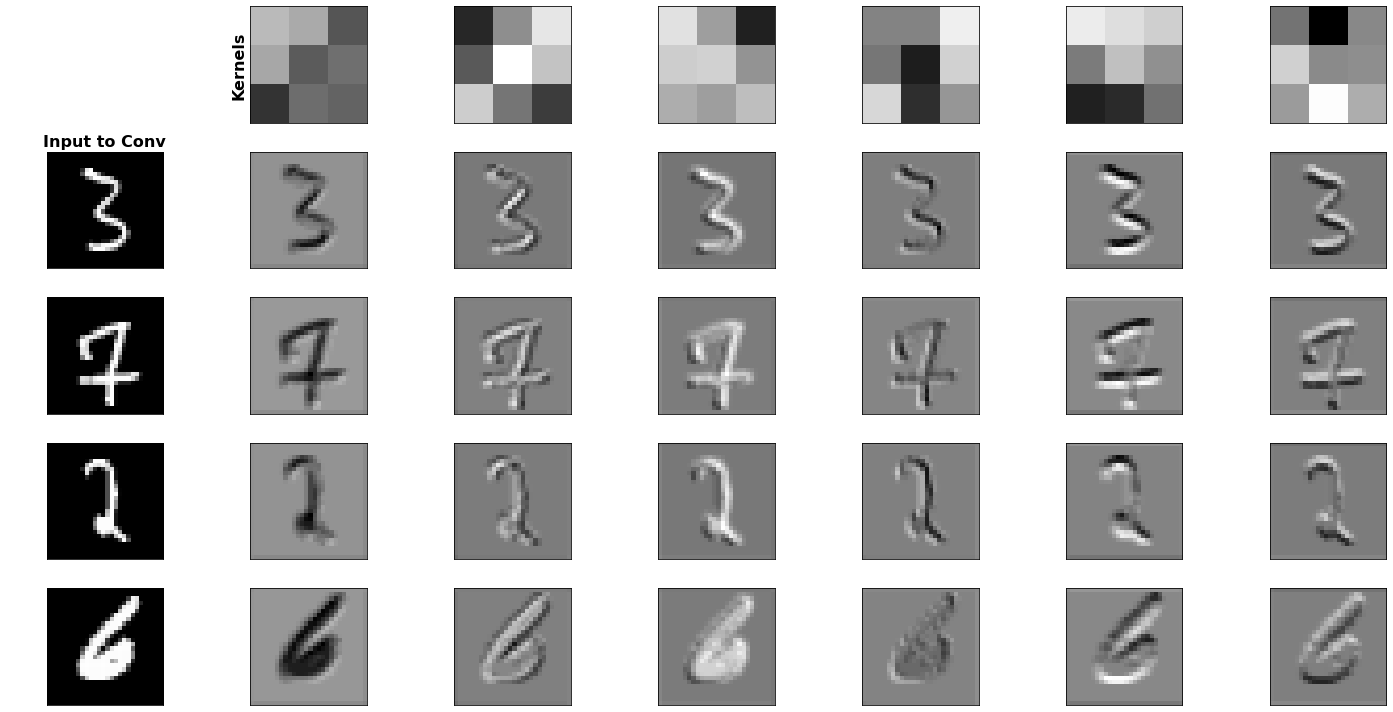

In [152]:
with torch.no_grad():
    kernels = cnn_layer._parameters['weight']
    kenerls_min, kernels_max = kernels.min(), kernels.max()        
    n_samples = len(x_ls)
    n_channels = len(kernels)
    fig, axes = plt.subplots(n_samples + 1, n_channels + 1, figsize=(20, 10))
    axes[0, 0].axis('off')
    axes[0, 1].set_ylabel("Kernels", fontsize=16, fontweight='bold')
    axes[1, 0].set_title("Input to Conv", fontsize=16, fontweight='bold')
    for filt_idx, ax in enumerate(axes[0, 1:]):
        ax.imshow(kernels[filt_idx].squeeze(), cmap='gray', vmin=kenerls_min, vmax=kernels_max)
    for x, ax in zip(x_ls, axes[1:, 0]):
        ax.imshow(x.numpy().transpose(1, 2, 0), cmap='gray')
    
    for sample_idx, x in enumerate(x_ls):
        for filt_idx in range(n_channels):
            ax = axes[sample_idx + 1, filt_idx + 1]
            out_min, out_max = cnn_layer(x).min(), cnn_layer(x).max()
            ax.imshow(cnn_layer(x)[filt_idx], cmap='gray', vmin=out_min, vmax=out_max)
    for ax in axes.flatten():
        ax.tick_params(axis='both', which='both', left=False, right=False, labelleft=False, labelbottom=False, bottom=False)
    plt.tight_layout()

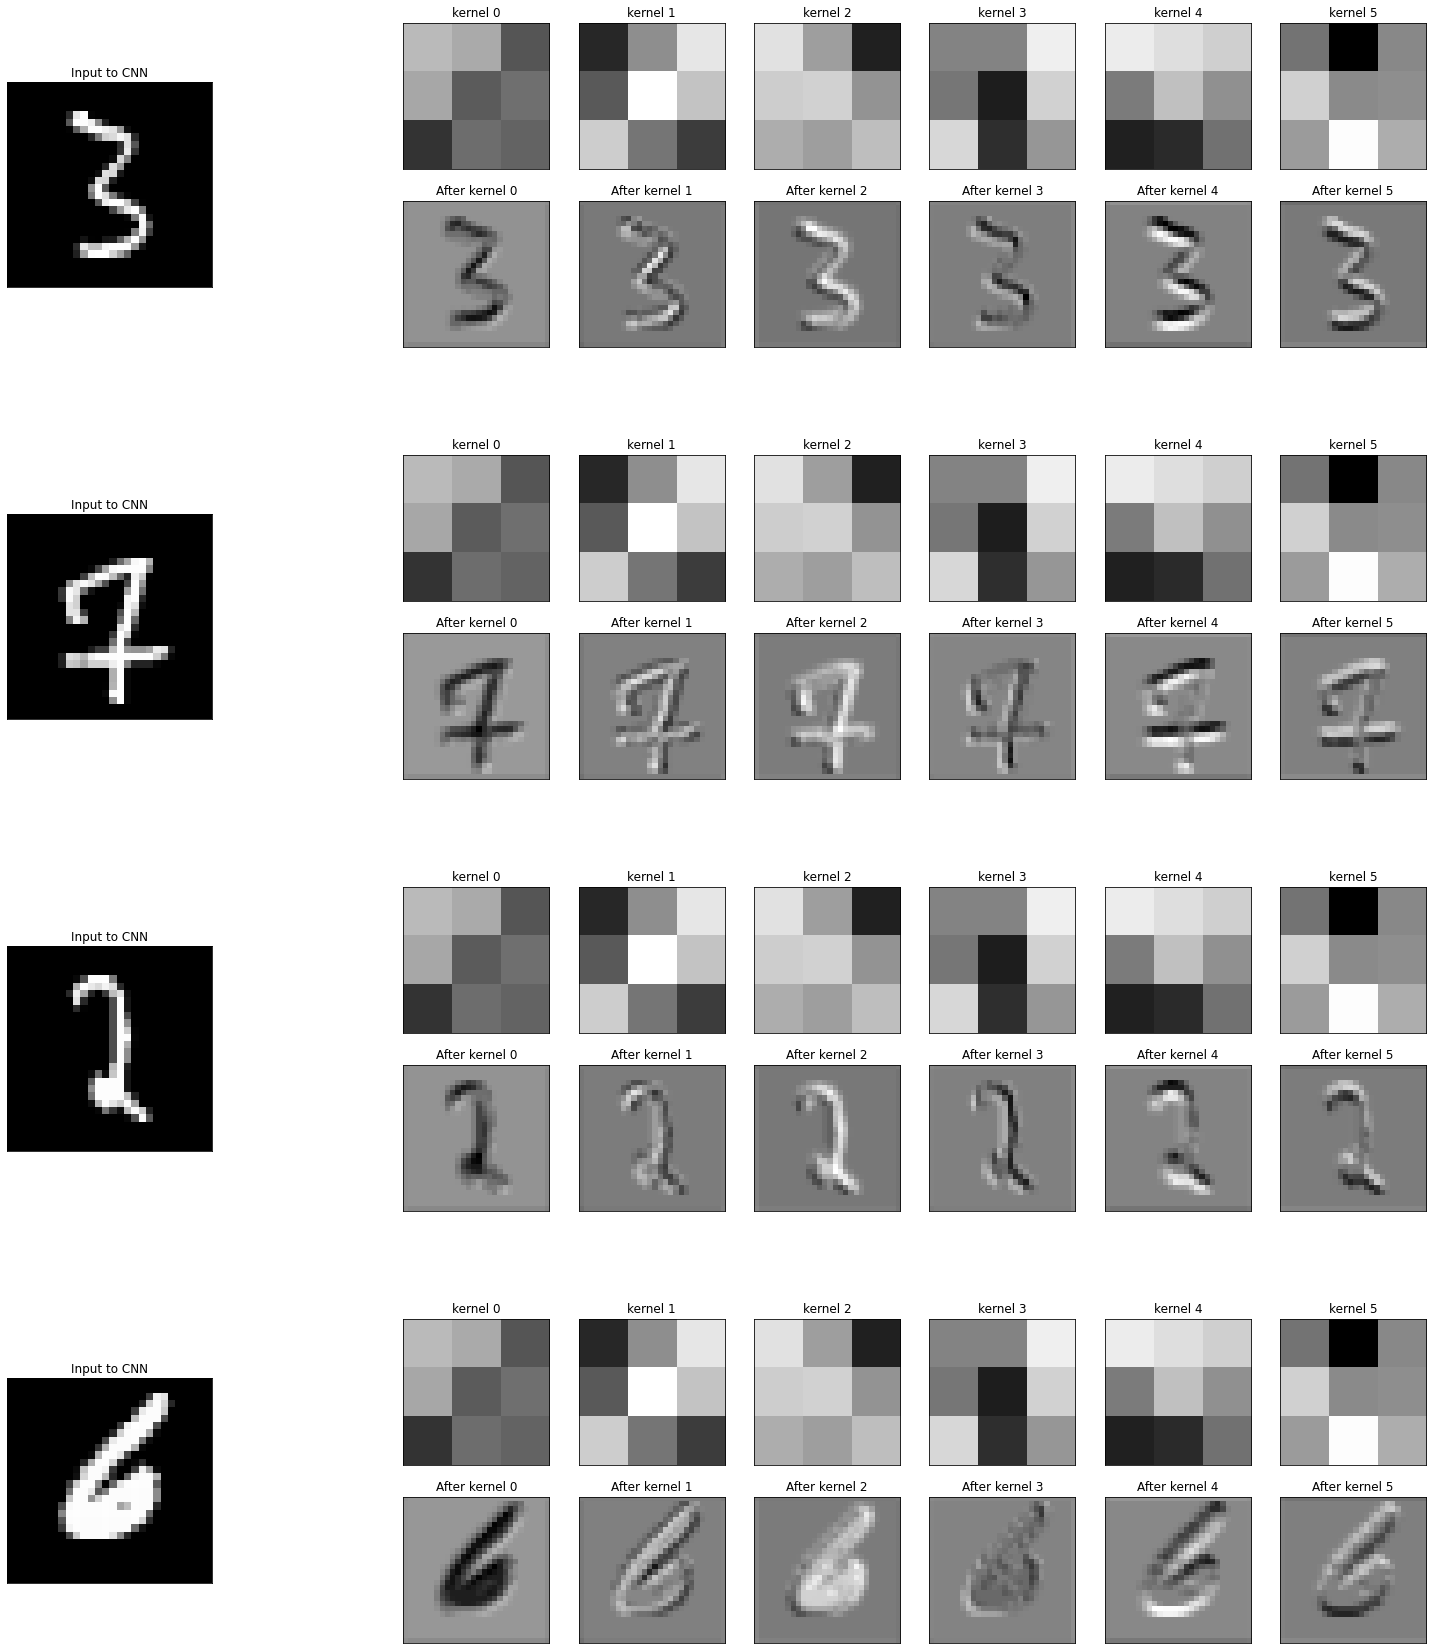

In [106]:
whole_fig = plt.figure(figsize=(22, 6*len(x_ls)))
figs = whole_fig.subfigures(len(x_ls), 1)
for fig, x in zip(figs, x_ls):
    subfigs = fig.subfigures(1, 2, wspace=0.05, width_ratios=[1, 5])
    ax_left = subfigs[0].subplots()
    axes_right = subfigs[1].subplots(2, 6)
    # plt.tight_layout()
    for ax in axes_right.flatten().tolist() + [ax_left]:
        ax.tick_params(axis='both', which='both', left=False, right=False, labelleft=False, labelbottom=False, bottom=False)

    ax_left.imshow(x.numpy().transpose(1, 2, 0), cmap='gray', vmin=x.min(), vmax=x.max())
    ax_left.set_title(f"Input to CNN")
    cnn_layer = image_classifier.classifier.model.cnn_block_1[0]
    with torch.no_grad():
        kenerls_min, kernels_max = cnn_layer._parameters['weight'].min(), cnn_layer._parameters['weight'].max()
        out_min, out_max = cnn_layer(x).min(), cnn_layer(x).max()
        for filt_idx in range(cnn_layer.out_channels):
            kernel = cnn_layer._parameters['weight'][filt_idx]
            axes_right[0, filt_idx].imshow(kernel.squeeze(), cmap='gray', vmin=kenerls_min, vmax=kernels_max)
            axes_right[1, filt_idx].imshow(cnn_layer(x)[filt_idx], cmap='gray', vmin=out_min, vmax=out_max)

            axes_right[0, filt_idx].set_title(f"kernel {filt_idx}")
            axes_right[1, filt_idx].set_title(f"After kernel {filt_idx}")        

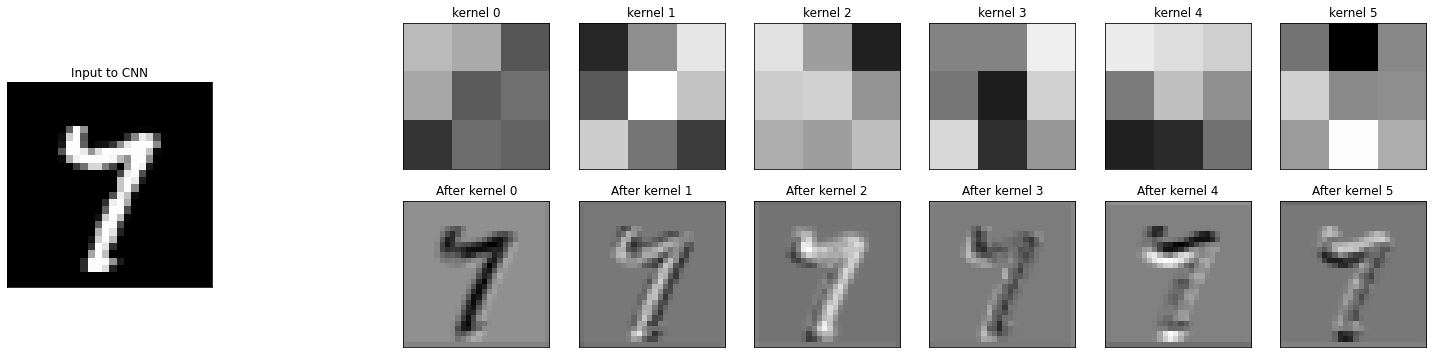

In [88]:
fig = plt.figure(figsize=(22, 6))
subfigs = fig.subfigures(1, 2, wspace=0.05, width_ratios=[1, 5])
ax_left = subfigs[0].subplots()
axes_right = subfigs[1].subplots(2, 6)
# plt.tight_layout()
for ax in axes_right.flatten().tolist() + [ax_left]:
    ax.tick_params(axis='both', which='both', left=False, right=False, labelleft=False, labelbottom=False, bottom=False)
    
ax_left.imshow(x.numpy().transpose(1, 2, 0), cmap='gray', vmin=x.min(), vmax=x.max())
ax_left.set_title(f"Input to CNN")
cnn_layer = image_classifier.classifier.model.cnn_block_1[0]
with torch.no_grad():
    kenerls_min, kernels_max = cnn_layer._parameters['weight'].min(), cnn_layer._parameters['weight'].max()
    out_min, out_max = cnn_layer(x).min(), cnn_layer(x).max()
    for filt_idx in range(cnn_layer.out_channels):
        kernel = cnn_layer._parameters['weight'][filt_idx]
        axes_right[0, filt_idx].imshow(kernel.squeeze(), cmap='gray', vmin=kenerls_min, vmax=kernels_max)
        axes_right[1, filt_idx].imshow(cnn_layer(x)[filt_idx], cmap='gray', vmin=out_min, vmax=out_max)
        
        axes_right[0, filt_idx].set_title(f"kernel {filt_idx}")
        axes_right[1, filt_idx].set_title(f"After kernel {filt_idx}")        

In [24]:
preds = []
labels = []

for x, label in tqdm(data.test_dataloader()):
    pred = image_classifier(x.cuda()).argmax(1)
    preds.append(pred)
    labels.append(label)
    
preds = torch.cat(preds, dim=0)
labels = torch.cat(labels, dim=0)

Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f1ffb0f0700><function _MultiProcessingDataLoaderIter.__del__ at 0x7f1ffb0f0700>

Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/shate/.local/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1358, in __del__
  File "/home/shate/.local/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1358, in __del__
Exception ignored in:         self._shutdown_workers()<function _MultiProcessingDataLoaderIter.__del__ at 0x7f1ffb0f0700>self._shutdown_workers()


  File "/home/shate/.local/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1341, in _shutdown_workers
Traceback (most recent call last):
  File "/home/shate/.local/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1341, in _shutdown_workers
  File "/home/shate/.local/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1358, in __del

  0%|          | 0/16 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f1ffb0f0700>
Exception ignored in: Traceback (most recent call last):
  File "/home/shate/.local/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1358, in __del__
Exception ignored in:     self._shutdown_workers()<function _MultiProcessingDataLoaderIter.__del__ at 0x7f1ffb0f0700><function _MultiProcessingDataLoaderIter.__del__ at 0x7f1ffb0f0700>


Exception ignored in: Exception ignored in: Exception ignored in: Exception ignored in:     Exception ignored in: Exception ignored in: Exception ignored in: Traceback (most recent call last):
<function _MultiProcessingDataLoaderIter.__del__ at 0x7f1ffb0f0700><function _MultiProcessingDataLoaderIter.__del__ at 0x7f1ffb0f0700><function _MultiProcessingDataLoaderIter.__del__ at 0x7f1ffb0f0700><function _MultiProcessingDataLoaderIter.__del__ at 0x7f1ffb0f0700>Traceback (most recent call last):
self._shutdown_workers()  File "/home/shate/.local/lib/pytho

In [30]:
accuracy_score(preds.cpu(), labels.cpu())

0.989

In [32]:
preds_2 = trainer.predict(image_classifier, test_dl)
preds_2 = torch.cat(preds_2, dim=0)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 938it [00:00, ?it/s]

PREDICT Profiler Report

------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|  Action                                                                                                                                                                                                    	|  Mean duration (s)	|  Num calls      	|  Total time (s) 	|  Percentage %   	|
------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|  Total                                                                   